<h1> Libraries Import </h1>

In [16]:
import datetime as dt
import yfinance as yf
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt 

# Data Download
This project works on S&P 500. The last 20-year data is used and acquired via the yfinance library.

In [17]:
# Download the past 20-year data
end = dt.datetime.today()
start = end - dt.timedelta(365*20)

stocks = ['^SPX']

data = {}

for ticker in stocks: 
    data[ticker] = yf.download(ticker,start,end)

print(data)

[*********************100%%**********************]  1 of 1 completed

{'^SPX':                    Open         High          Low        Close    Adj Close  \
Date                                                                          
2004-07-16  1106.689941  1112.170044  1101.069946  1101.390015  1101.390015   
2004-07-19  1101.390015  1105.520020  1096.550049  1100.900024  1100.900024   
2004-07-20  1100.900024  1108.880005  1099.099976  1108.670044  1108.670044   
2004-07-21  1108.670044  1116.270020  1093.880005  1093.880005  1093.880005   
2004-07-22  1093.880005  1099.660034  1084.160034  1096.839966  1096.839966   
...                 ...          ...          ...          ...          ...   
2024-07-03  5507.439941  5539.270020  5507.419922  5537.020020  5537.020020   
2024-07-05  5537.910156  5570.330078  5531.629883  5567.189941  5567.189941   
2024-07-08  5572.750000  5583.109863  5562.509766  5572.850098  5572.850098   
2024-07-09  5584.240234  5590.750000  5574.569824  5576.979980  5576.979980   
2024-07-10  5591.259766  5635.390137  5586.

<h1> Data Engineering </h1>

<p> Data are prepared for the regime detection model input by following a few crucial steps: </p>
<ul>
        <li> Handling Missing Information: missing data for weekends and holidays are filled in using forward fill to ensure continuity in the dataset. </li> 
        <li> Adding a New Feature: Log Returns, which is derived from the 12-day moving average of historical close prices. 
                <ul>
                        <li> Why Use Log Returns? 
                                <ul>
                                        <li> Symmetry and Additivity: Log returns are symmetric and additive over time, providing a consistent measure when comparing across different periods. </li>
                                        <li> Normalization: Log returns are normalized to the current price and are unaffected by the level of the asset's price, making them ideal for comparing the performance of different instruments. </li>
                                </ul>
                        </li>
                        <li> Why Use a Moving Average instead of raw prices? 
                                <ul>
                                        <li> Reduce Noise: The moving average filters out random noise in the time series, smoothing out short-term fluctuations. </li>
                                        <li> Focus on Long-term Trends: This approach highlights long-term price movements, offering a clearer view of underlying trends. </li>
                                </ul>
                        </li>
                </ul>
        </li>
</ul>

In [18]:
def prepare_data_for_model_input(close_prices, ma_period):
    '''
        Input: 
            close_prices (df) - Dataframe of close prices
            ma_period (int) - Length of the moving average

        Output:
            input_df (df) - Enhanced dataframe of close prices with moving average and log return columns
            log_return_array (np.array) - an array of the log return
    '''
    input_df = pd.DataFrame(close_prices, columns=['Close'])
    input_df[f'{ma_period} MA'] = input_df['Close'].rolling(ma_period).mean()
    input_df['Log Return'] = np.log( input_df[f'{ma_period} MA'] / input_df[f'{ma_period} MA'].shift(1))
    input_df.dropna(inplace=True)
    log_return_array = np.array(input_df['Log Return']).reshape(-1,1)
    return input_df, log_return_array

In [19]:
# Add weekends and holidays using forward fill
for stock in stocks:
    data[stock] = data[stock].asfreq("D")
    data[stock].fillna(method='ffill', inplace=True)
    
stock_data = data['^SPX']
stock_data_close = data['^SPX']['Close']


# Add new feature: log return
ma_period = 12
input_data, log_return_array = prepare_data_for_model_input(stock_data_close, ma_period=12)

print(input_data)
print(log_return_array)

                  Close        12 MA  Log Return
Date                                            
2004-07-28  1095.420044  1094.665822   -0.000454
2004-07-29  1100.430054  1094.585826   -0.000073
2004-07-30  1101.719971  1094.613322    0.000025
2004-07-31  1101.719971  1094.681651    0.000062
2004-08-01  1101.719971  1094.102478   -0.000529
...                 ...          ...         ...
2024-07-06  5567.189941  5500.335775    0.001809
2024-07-07  5567.189941  5508.493286    0.001482
2024-07-08  5572.850098  5516.405802    0.001435
2024-07-09  5576.979980  5524.248291    0.001421
2024-07-10  5633.910156  5538.700806    0.002613

[7288 rows x 3 columns]
[[-4.54371127e-04]
 [-7.30813608e-05]
 [ 2.51199969e-05]
 ...
 [ 1.43539049e-03]
 [ 1.42065676e-03]
 [ 2.61277942e-03]]


<h1> Modeling and In-Sample Testing </h1>

In [36]:
class RegimeDetection:
    '''
        A python class that encapsulates three functions to determine market regimes: Agglomerative Clustering, Gaussian Mixture Models (GMM), and Hidden Markov Models (HMM)
        
        For each function within the class:
        Input:
            input_data (np.array) - Log return 
            params (dict) - Model parameters
        
        Output:
            return the respective model
    '''
    def get_regimes_hmm(self, input_data, params):
        hmm_model = self.initilise_model(GaussianHMM(), params).fit(input_data)
        return hmm_model

    def get_regimes_clustering(self, params):
        clustering = self.initilise_model(AgglomerativeClustering(), params)
        return clustering
    
    def get_regimes_gmm(self, input_data, params):
        gmm = self.initilise_model(GaussianMixture(), params).fit(input_data)
        return gmm
    
    def initilise_model(self, model, params):
        for parameter, value in params.items():
            setattr(model, parameter, value)
        return model
    
    def relabel(states):
        if (states==0).sum() < (states==1).sum():
            states = 1 - states
        return states


In [21]:
def plot_regime_detection(model, input_data, clustering_states):
    plt.figure(figsize=(10,5))
    plt.scatter(input_data['Close'].index[clustering_states==0], input_data['Close'][clustering_states==0], color='green', label='Cluster 0')
    plt.scatter(input_data['Close'].index[clustering_states==1], input_data['Close'][clustering_states==1], color='red', label='Cluster 1')
    plt.title(f'Regime Dectection - {model}')
    plt.legend()
    plt.show()

In [37]:
# Initialize the model
regime_detection = RegimeDetection()

Number of observations for State 0: 6857
Number of observations for State 1: 431


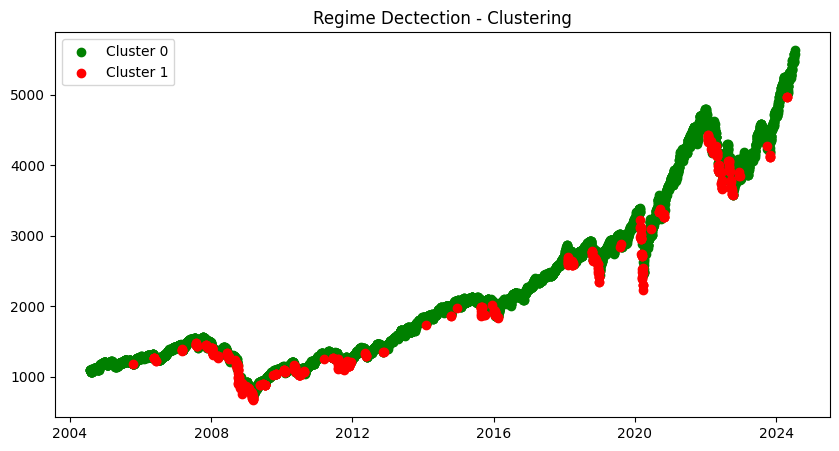

In [42]:
## 1st method: clustering
params = {'n_clusters': 2, 'linkage': 'complete', 'metric': 'manhattan', 'random_state': 100}
clustering = regime_detection.get_regimes_clustering(params)
clustering_states = clustering.fit_predict(log_return_array)
clustering_states = RegimeDetection.relabel(clustering_states)
print(f'Number of observations for State 0: {len(clustering_states) - clustering_states.sum()}')
print(f'Number of observations for State 1: {clustering_states.sum()}')
### Plot the resulting clustering 

plot_regime_detection('Clustering', input_data, clustering_states)

Number of observations for State 0: 6972
Number of observations for State 1: 316


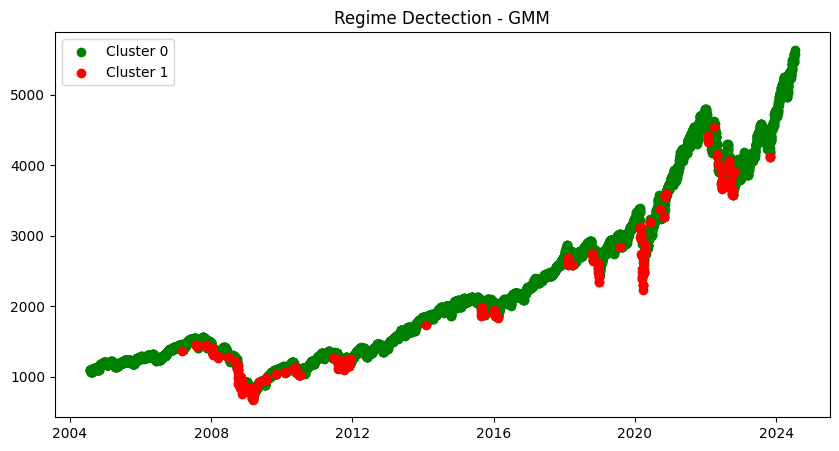

In [45]:
## 2nd method: GMM
params = {'n_components':2, 'covariance_type': 'full', 'max_iter': 100000, 'n_init': 30,'init_params': 'kmeans', 'random_state':100}
gmm_model = regime_detection.get_regimes_gmm(log_return_array, params)
gmm_states = gmm_model.predict(log_return_array)
gmm_states = RegimeDetection.relabel(gmm_states)
print(f'Number of observations for State 0: {len(gmm_states) - gmm_states.sum()}')
print(f'Number of observations for State 1: {gmm_states.sum()}')
### Plot the resulting clustering 
plot_regime_detection('GMM', input_data, gmm_states)

Number of observations for State 0: 6679
Number of observations for State 1: 609


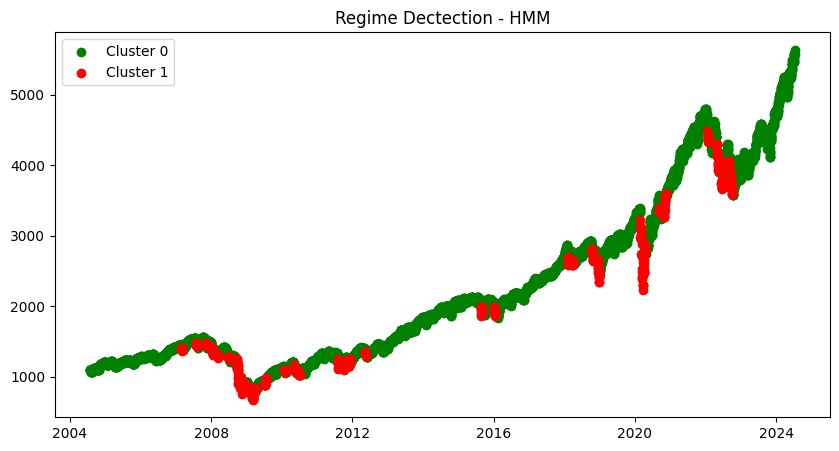

In [46]:
## 3rd method: HMM
params = {'n_components':2, 'covariance_type':"full", 'random_state':100}
hmm_model = regime_detection.get_regimes_hmm(log_return_array, params)
hmm_states = hmm_model.predict(log_return_array)
hmm_states = RegimeDetection.relabel(hmm_states)
print(f'Number of observations for State 0: {len(hmm_states) - hmm_states.sum()}')
print(f'Number of observations for State 1: {hmm_states.sum()}')
### Plot the resulting clustering 
plot_regime_detection('HMM', input_data, hmm_states)

<h2> Findings </h2> 

<p> Inspecting the graphs, we see that 
    <ul> 
        <li> GMM and HMM do a better job that Agglomerative clustering </li>
        <li> HMM's states continuity is steadier than GMM's </li>
    </ul> 
</p> 

<h1> Feed-forward Training and Out-of-Sample Testing </h1>
<p> Feed-forward training and out-of-sample testing are implemented for the GMM and HMM models to further investigate their robustness. </p>

In [26]:
# Feed-forward training and out of semple testing
def feed_forward_training(model, params, log_return_array, split_index, retrain_step):
    '''
        Function that trains the HMM or GMM model on an initial training dataset, predicts the state of the next observation, and retrains the model after the specified training step.
        
        Input:
            model (<class 'method'>) - either gmm (Gaussian Mixture Models) or hmm (Hidden Markov Model)
            params (dict) - Model parameters
            log_return_array (np.array) - Log return
            split_index (int) - Index to split initial training and testing dataset
            retrain_step (int) - Number of new observations to initiate model retraining
        Output:
            states_pred (np.array) - Predicted states
    '''

    # Train/test split and initial model training
    init_train_data = log_return_array[:split_index]
    init_test_data = log_return_array[split_index:]
    rd_model = model(init_train_data, params)
    states_pred = rd_model.predict(log_return_array[:split_index]).tolist()
    # Predict the state of the next observation
    for i in range(len(init_test_data)):
        split_index += 1
        preds = rd_model.predict(log_return_array[:split_index]).tolist()
        states_pred.append(preds[-1])
        
        # Retrain the existing model
        if i % retrain_step == 0:
            rd_model = model(log_return_array[:split_index], params)
            
    return np.array(states_pred)

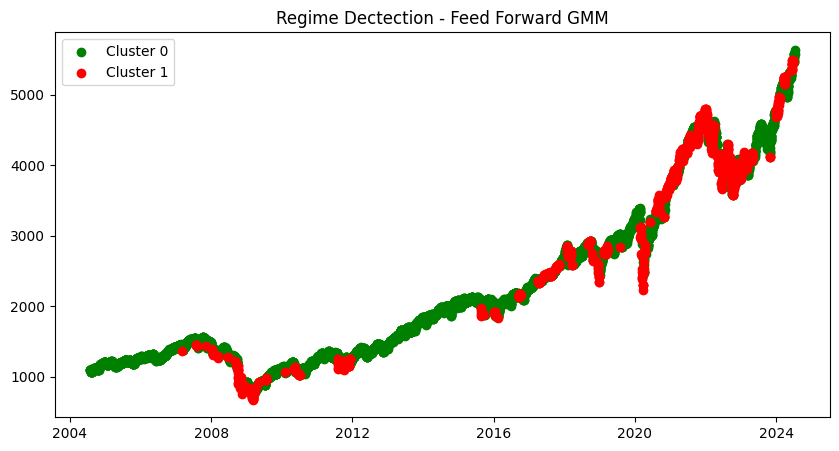

In [47]:
# Run feed-forward training model with GMM
ff_gmm = regime_detection.get_regimes_gmm
params = {'n_components':2, 'covariance_type': 'full', 'max_iter': 100000, 'n_init': 30,'init_params': 'kmeans', 'random_state':100}
init_train_size = .6
split_index = int(len(log_return_array) * init_train_size)

ff_gmm_states = feed_forward_training(ff_gmm, params, log_return_array, split_index, retrain_step=20)
ff_gmm_states = RegimeDetection.relabel(ff_gmm_states)
plot_regime_detection('Feed Forward GMM', input_data, ff_gmm_states)

<h2> Findings </h2>

<p> GMM performs worse in out-of-sample testing. </p>

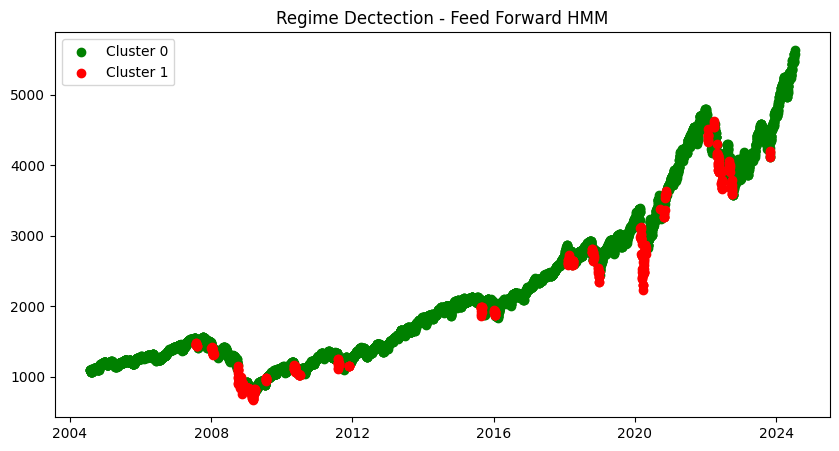

In [48]:
# Run feed-forward training model with HMM
ff_hmm = regime_detection.get_regimes_hmm
params = {'n_components':2, 'covariance_type':"full", 'random_state':100}
init_train_size = .6
split_index = int(len(log_return_array) * init_train_size)

ff_hmm_states = feed_forward_training(ff_hmm, params, log_return_array, split_index, retrain_step=20)
ff_hmm_states = RegimeDetection.relabel(ff_hmm_states)
plot_regime_detection('Feed Forward HMM', input_data, ff_hmm_states)


<h2> Findings </h2> 

<p> HMM continues to perform better than GMM, even in out-of-sample testing. </p>

<h1> Backtesting Investment Strategy using HMM</h1>

<p> 
    <ul>
        <li> Position decision:
            <ul>
                <li> Long when market is expected to stay in normal or up state </li>
                <li> Short when market is expected to stay in down state </li>
            </ul>
        </li>
        <li> Implementation:
            <ul>
                <li> The position for the day is determined based on the previous day's state prediction because the HMM model predicts the state at the end of each day based on the day's data. </li>
                <li> Daily returns are equal to the position signal (from the previous day) multipied by the current day's log return. </li>
                <li> Cumulative returns are calculated for both the HMM-based strategy and a simple buy-and-hold strategy for comparison. </li>
            </ul>
        </li>
    </ul>
</p>

In [29]:
prices_with_states = pd.DataFrame(stock_data_close[ma_period:])
prices_with_states['HMM State'] = ff_hmm_states
prices_with_states['Log Return'] = np.log(prices_with_states['Close']/prices_with_states['Close'].shift(1))
prices_with_states['HMM Position'] = np.where(prices_with_states['HMM State'] == 0, 1, -1)
prices_with_states['HMM Daily Outcome'] = prices_with_states['HMM Position'].shift(1) * prices_with_states['Log Return']
prices_with_states['HMM Cumulative Outcome'] = prices_with_states['HMM Daily Outcome'].cumsum()
prices_with_states['Buy&Hold Cumulative Outcome'] = prices_with_states['Log Return'].cumsum()

In [30]:
prices_with_states

,Close,HMM State,Log Return,HMM Position,HMM Daily Outcome,HMM Cumulative Outcome,Buy&Hold Cumulative Outcome
Date,,,,,,,
2004-07-28,1095.420044,0,NaN,1,NaN,NaN,NaN
2004-07-29,1100.430054,0,0.004563,1,0.004563,0.004563,0.004563
2004-07-30,1101.719971,0,0.001172,1,0.001172,0.005735,0.005735
2004-07-31,1101.719971,0,0.000000,1,0.000000,0.005735,0.005735
2004-08-01,1101.719971,0,0.000000,1,0.000000,0.005735,0.005735
...,...,...,...,...,...,...,...
2024-07-06,5567.189941,0,0.000000,1,0.000000,2.322923,1.625753
2024-07-07,5567.189941,0,0.000000,1,0.000000,2.322923,1.625753
2024-07-08,5572.850098,0,0.001016,1,0.001016,2.323939,1.626769


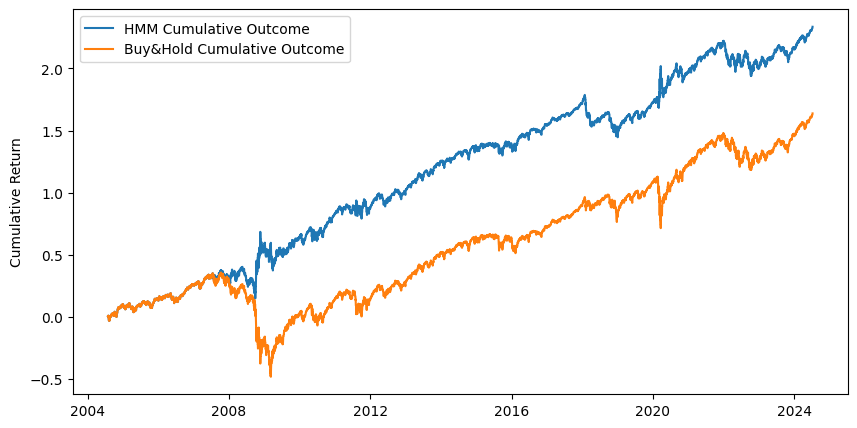

In [31]:
# Plot the cumulative return
plt.figure(figsize=(10,5))
plt.plot(prices_with_states['HMM Cumulative Outcome'], label='HMM Cumulative Outcome')
plt.plot(prices_with_states['Buy&Hold Cumulative Outcome'], label='Buy&Hold Cumulative Outcome')
plt.legend()
plt.ylabel('Cumulative Return')
plt.show()

<h2> Findings </h2>

<p> According to the graph, the HMM-based strategy outperforms the base Buy and Hold strategy. </p>

<p> However, note that the investment strategy simply accumulates daily profit/loss based on the price change. An enhanced model may be develop to incorporate further refinement to include transaction fees, slippage costs, margin calls, etc.</p>